# Perturbation Effect Analysis

This notebook analyzes the effects of gene knockouts on expression profiles by:
1. Computing per-perturbation centroids in the HVG expression space
2. Comparing each knockout centroid to the Negative Control (NC) centroid
3. Analyzing shifts in program proportions (pre_adipo, adipo, other, lipo, lipo_adipo)
4. Identifying patterns and clustering perturbations by their effects

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100, facecolor='white')

## 1. Load Data

In [2]:
# Load the training data
adata = sc.read_h5ad('obesity_challenge_1.h5ad')
print(f"Dataset shape: {adata.shape}")
print(f"\nobs columns: {list(adata.obs.columns)}")

Dataset shape: (44846, 11046)

obs columns: ['nCount_RNA', 'nFeature_RNA', 'nCount_guide', 'nFeature_guide', 'percent.mt', 'SampleID', 'Day', 'num_features', 'feature_call', 'num_umis', 'gene', 'adipo', 'pre_adipo', 'other', 'lipo']


In [3]:
# Load program proportions reference
program_props = pd.read_csv('program_proportion.csv')
program_props.set_index('gene', inplace=True)
print(f"Program proportions shape: {program_props.shape}")
print(f"\nProgram columns: {list(program_props.columns)}")
print(f"\nFirst 10 perturbations:")
program_props.head(10)

Program proportions shape: (123, 5)

Program columns: ['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo']

First 10 perturbations:


,pre_adipo,adipo,other,lipo,lipo_adipo
gene,,,,,
HIF1A,0.304972,0.237569,0.457459,0.060773,0.255814
ZNF26,0.427457,0.268331,0.304212,0.057722,0.215116
TWIST1,0.451327,0.223009,0.325664,0.067257,0.301587
CEBPA,0.461864,0.086864,0.451271,0.014831,0.170732
HIF3A,0.431746,0.223810,0.344444,0.065079,0.290780
TSHZ2,0.435484,0.209677,0.354839,0.069892,0.333333
TRRAP,0.345476,0.289072,0.365452,0.085781,0.296748
RB1,0.441501,0.225166,0.333333,0.059603,0.264706
ZFP2,0.331034,0.321839,0.347126,0.075862,0.235714


In [ ]:
# Load HVGs from previous analysis
with open('highly_variable_genes.txt', 'r') as f:
    hvgs = [line.strip() for line in f.readlines()]
print(f"Loaded {len(hvgs)} highly variable genes")

# Verify HVGs are in the dataset
hvgs_in_data = [g for g in hvgs if g in adata.var_names]
print(f"HVGs found in dataset: {len(hvgs_in_data)}")

Loaded 2000 highly variable genes
HVGs found in dataset: 2000


## 2. Compute Per-Perturbation Centroids

In [5]:
# Subset to HVGs for centroid computation
adata_hvg = adata[:, hvgs_in_data].copy()

# Normalize for centroid computation
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)

print(f"HVG subset shape: {adata_hvg.shape}")

normalizing counts per cell
    finished (0:00:17)
HVG subset shape: (44846, 2000)


In [7]:
# Compute centroids for each perturbation
perturbations = adata_hvg.obs['gene'].unique()
print(f"Computing centroids for {len(perturbations)} perturbations...")

centroids = {}
cell_counts = {}

for pert in perturbations:
    mask = adata_hvg.obs['gene'] == pert
    cells = adata_hvg[mask]
    centroids[pert] = np.array(cells.X.mean(axis=0)).flatten()
    cell_counts[pert] = mask.sum()

# Create centroid DataFrame
centroid_df = pd.DataFrame(centroids, index=hvgs_in_data).T
print(f"\nCentroid matrix shape: {centroid_df.shape}")
print(f"\nCell counts per perturbation (summary):")
print(f"  Min: {min(cell_counts.values())}")
print(f"  Max: {max(cell_counts.values())}")
print(f"  Mean: {np.mean(list(cell_counts.values())):.1f}")

Computing centroids for 123 perturbations...

Centroid matrix shape: (123, 2000)

Cell counts per perturbation (summary):
  Min: 41
  Max: 8705
  Mean: 364.6


## 3. Compare Perturbations to Control (NC)

In [8]:
# Get the NC (Negative Control) centroid
nc_centroid = centroid_df.loc['NC']
print(f"NC centroid computed from {cell_counts['NC']} cells")

# Compute distances from each perturbation to NC
distances = {}
for pert in centroid_df.index:
    if pert != 'NC':
        pert_centroid = centroid_df.loc[pert]
        distances[pert] = {
            'euclidean': euclidean(pert_centroid, nc_centroid),
            'cosine': cosine(pert_centroid, nc_centroid),
            'cell_count': cell_counts[pert]
        }

distance_df = pd.DataFrame(distances).T
distance_df = distance_df.sort_values('euclidean', ascending=False)
print(f"\nTop 20 perturbations by Euclidean distance from NC:")
distance_df.head(20)

NC centroid computed from 8705 cells

Top 20 perturbations by Euclidean distance from NC:


,euclidean,cosine,cell_count
RNASEH2C,12.122114,0.018520,300.0
FAM136A,8.606647,0.009391,294.0
EP400,6.968398,0.006097,300.0
SRPK1,6.641146,0.005317,41.0
TMEM107,6.599903,0.005516,212.0
CEBPA,6.094033,0.004676,300.0
CEBPB,4.963653,0.003116,294.0
NFIB,4.893386,0.003029,300.0
SMAD2,4.886303,0.003017,300.0
PHF3,4.739094,0.002840,300.0


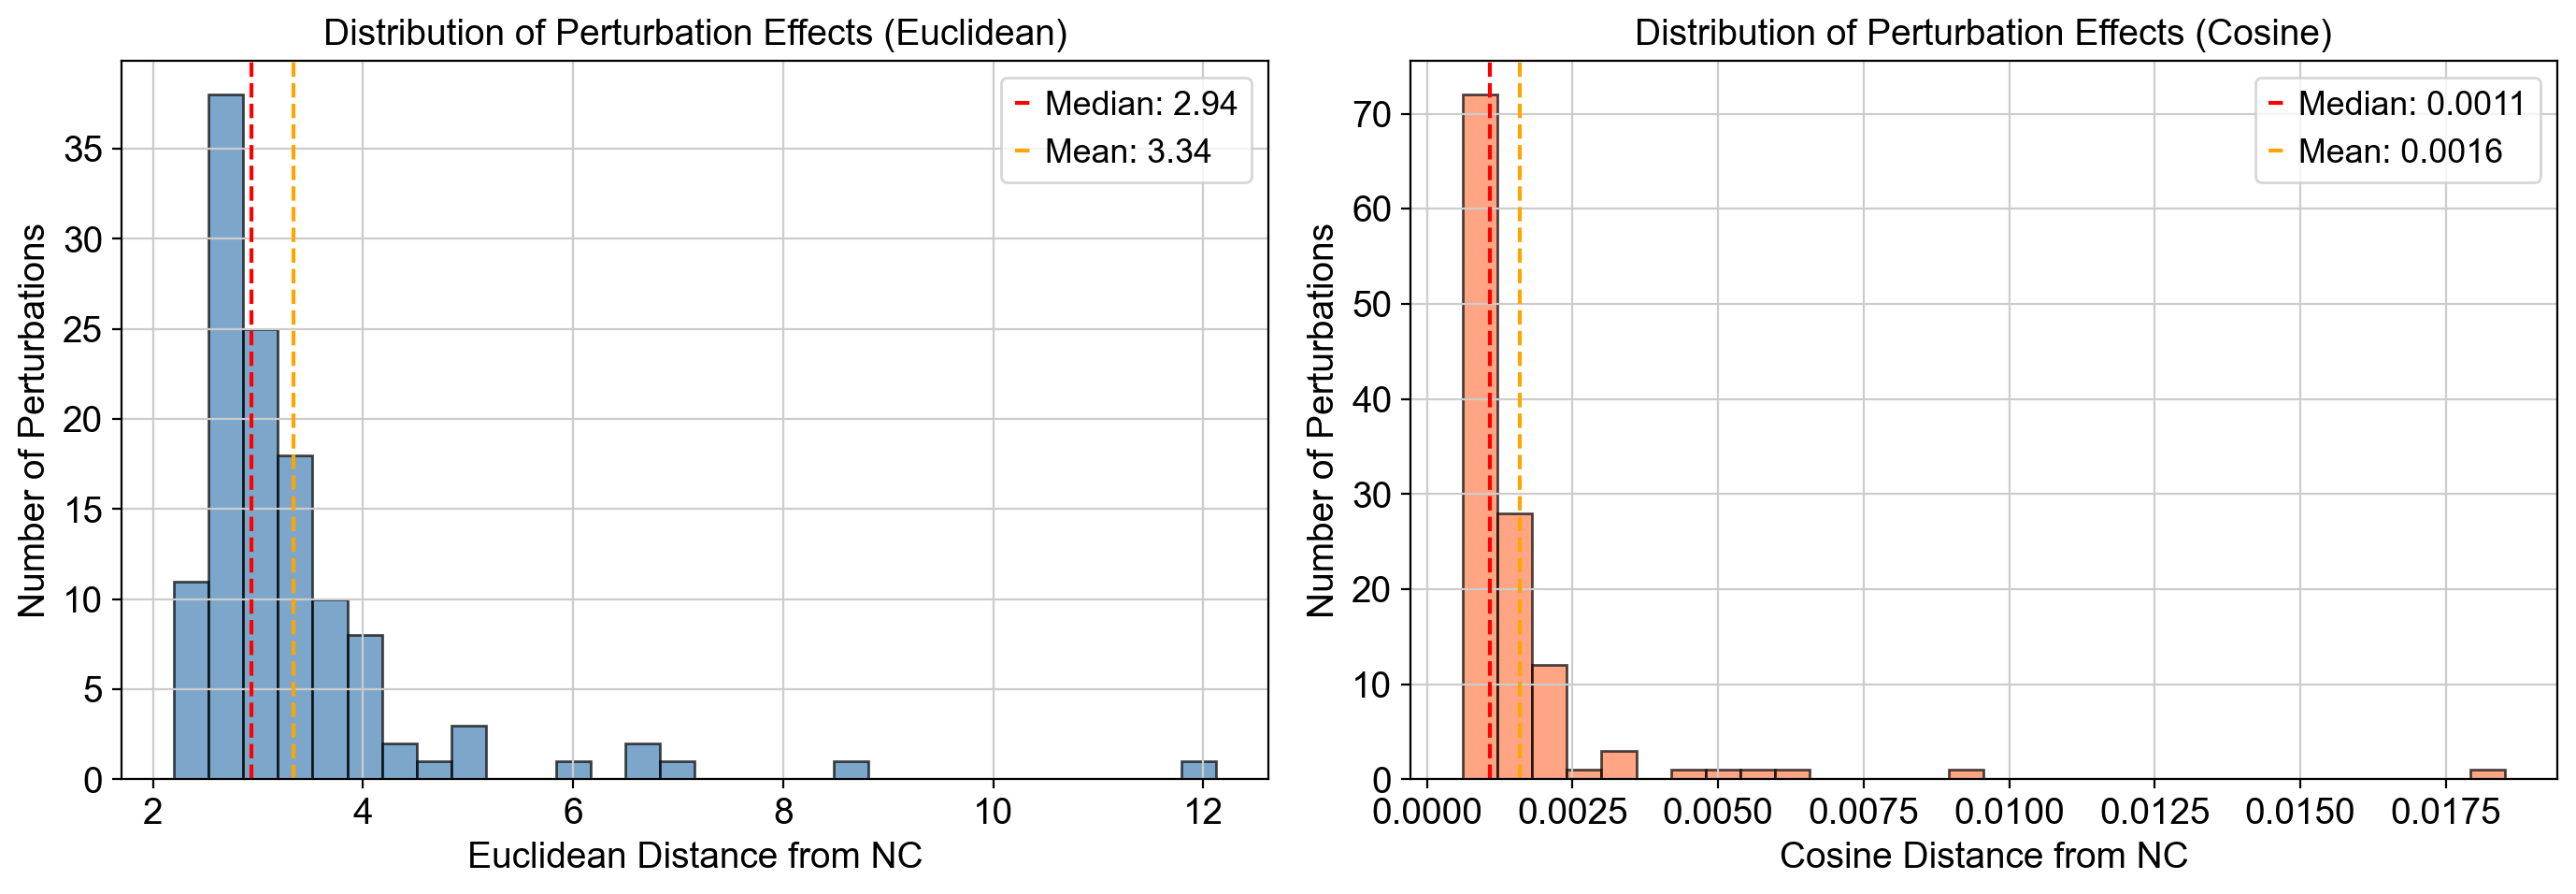

In [9]:
# Visualize distance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Euclidean distance distribution
axes[0].hist(distance_df['euclidean'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(distance_df['euclidean'].median(), color='red', linestyle='--', label=f"Median: {distance_df['euclidean'].median():.2f}")
axes[0].axvline(distance_df['euclidean'].mean(), color='orange', linestyle='--', label=f"Mean: {distance_df['euclidean'].mean():.2f}")
axes[0].set_xlabel('Euclidean Distance from NC')
axes[0].set_ylabel('Number of Perturbations')
axes[0].set_title('Distribution of Perturbation Effects (Euclidean)')
axes[0].legend()

# Cosine distance distribution
axes[1].hist(distance_df['cosine'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(distance_df['cosine'].median(), color='red', linestyle='--', label=f"Median: {distance_df['cosine'].median():.4f}")
axes[1].axvline(distance_df['cosine'].mean(), color='orange', linestyle='--', label=f"Mean: {distance_df['cosine'].mean():.4f}")
axes[1].set_xlabel('Cosine Distance from NC')
axes[1].set_ylabel('Number of Perturbations')
axes[1].set_title('Distribution of Perturbation Effects (Cosine)')
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/perturbation_distance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Top and bottom perturbations by effect size
print("=" * 60)
print("TOP 15 STRONGEST PERTURBATION EFFECTS (Furthest from NC)")
print("=" * 60)
for i, (pert, row) in enumerate(distance_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {pert:15s} | Euclidean: {row['euclidean']:6.3f} | Cosine: {row['cosine']:.4f} | Cells: {int(row['cell_count'])}")

print("\n" + "=" * 60)
print("TOP 15 WEAKEST PERTURBATION EFFECTS (Closest to NC)")
print("=" * 60)
for i, (pert, row) in enumerate(distance_df.tail(15).iterrows(), 1):
    print(f"{i:2d}. {pert:15s} | Euclidean: {row['euclidean']:6.3f} | Cosine: {row['cosine']:.4f} | Cells: {int(row['cell_count'])}")

TOP 15 STRONGEST PERTURBATION EFFECTS (Furthest from NC)
 1. RNASEH2C        | Euclidean: 12.122 | Cosine: 0.0185 | Cells: 300
 2. FAM136A         | Euclidean:  8.607 | Cosine: 0.0094 | Cells: 294
 3. EP400           | Euclidean:  6.968 | Cosine: 0.0061 | Cells: 300
 4. SRPK1           | Euclidean:  6.641 | Cosine: 0.0053 | Cells: 41
 5. TMEM107         | Euclidean:  6.600 | Cosine: 0.0055 | Cells: 212
 6. CEBPA           | Euclidean:  6.094 | Cosine: 0.0047 | Cells: 300
 7. CEBPB           | Euclidean:  4.964 | Cosine: 0.0031 | Cells: 294
 8. NFIB            | Euclidean:  4.893 | Cosine: 0.0030 | Cells: 300
 9. SMAD2           | Euclidean:  4.886 | Cosine: 0.0030 | Cells: 300
10. PHF3            | Euclidean:  4.739 | Cosine: 0.0028 | Cells: 300
11. TCEAL1          | Euclidean:  4.306 | Cosine: 0.0023 | Cells: 300
12. CNOT8           | Euclidean:  4.226 | Cosine: 0.0022 | Cells: 295
13. DEK             | Euclidean:  4.156 | Cosine: 0.0022 | Cells: 300
14. EWSR1           | Euclidean:  

## 4. Analyze Program Proportion Shifts

In [11]:
# Get NC reference proportions
nc_props = program_props.loc['NC']
print("NC (Control) Program Proportions:")
print(nc_props)

# Compute shifts relative to NC
program_shifts = program_props.copy()
for col in program_props.columns:
    program_shifts[col] = program_props[col] - nc_props[col]

# Remove NC from shifts (it's all zeros)
program_shifts = program_shifts.drop('NC', errors='ignore')
print(f"\nProgram shifts computed for {len(program_shifts)} perturbations")

NC (Control) Program Proportions:
pre_adipo     0.366456
adipo         0.257553
other         0.375991
lipo          0.069960
lipo_adipo    0.271632
Name: NC, dtype: float64

Program shifts computed for 122 perturbations


In [12]:
# Identify perturbations with strongest program shifts
program_shifts['total_shift'] = program_shifts.abs().sum(axis=1)
program_shifts_sorted = program_shifts.sort_values('total_shift', ascending=False)

print("Top 20 perturbations by total program proportion shift:")
program_shifts_sorted[['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo', 'total_shift']].head(20)

Top 20 perturbations by total program proportion shift:


,pre_adipo,adipo,other,lipo,lipo_adipo,total_shift
gene,,,,,,
RNASEH2C,-0.188737,0.336611,-0.147874,0.229775,0.232832,1.135829
FAM136A,-0.121558,0.239046,-0.117487,0.120516,0.111929,0.710537
EP400,-0.084512,0.174391,-0.089880,0.136985,0.207467,0.693234
TMEM107,-0.097588,0.143390,-0.045802,0.118719,0.198956,0.604456
CEBPA,0.095408,-0.170689,0.075280,-0.055129,-0.100901,0.497407
SRPK1,0.048178,-0.062431,0.014253,-0.069960,-0.271632,0.466455
NFIB,-0.061735,0.137297,-0.075562,0.064518,0.068947,0.408059
PPARD,0.018159,0.037319,-0.055478,0.068929,0.199382,0.379267
SMAD2,-0.041556,0.125936,-0.084380,0.059201,0.065173,0.376246


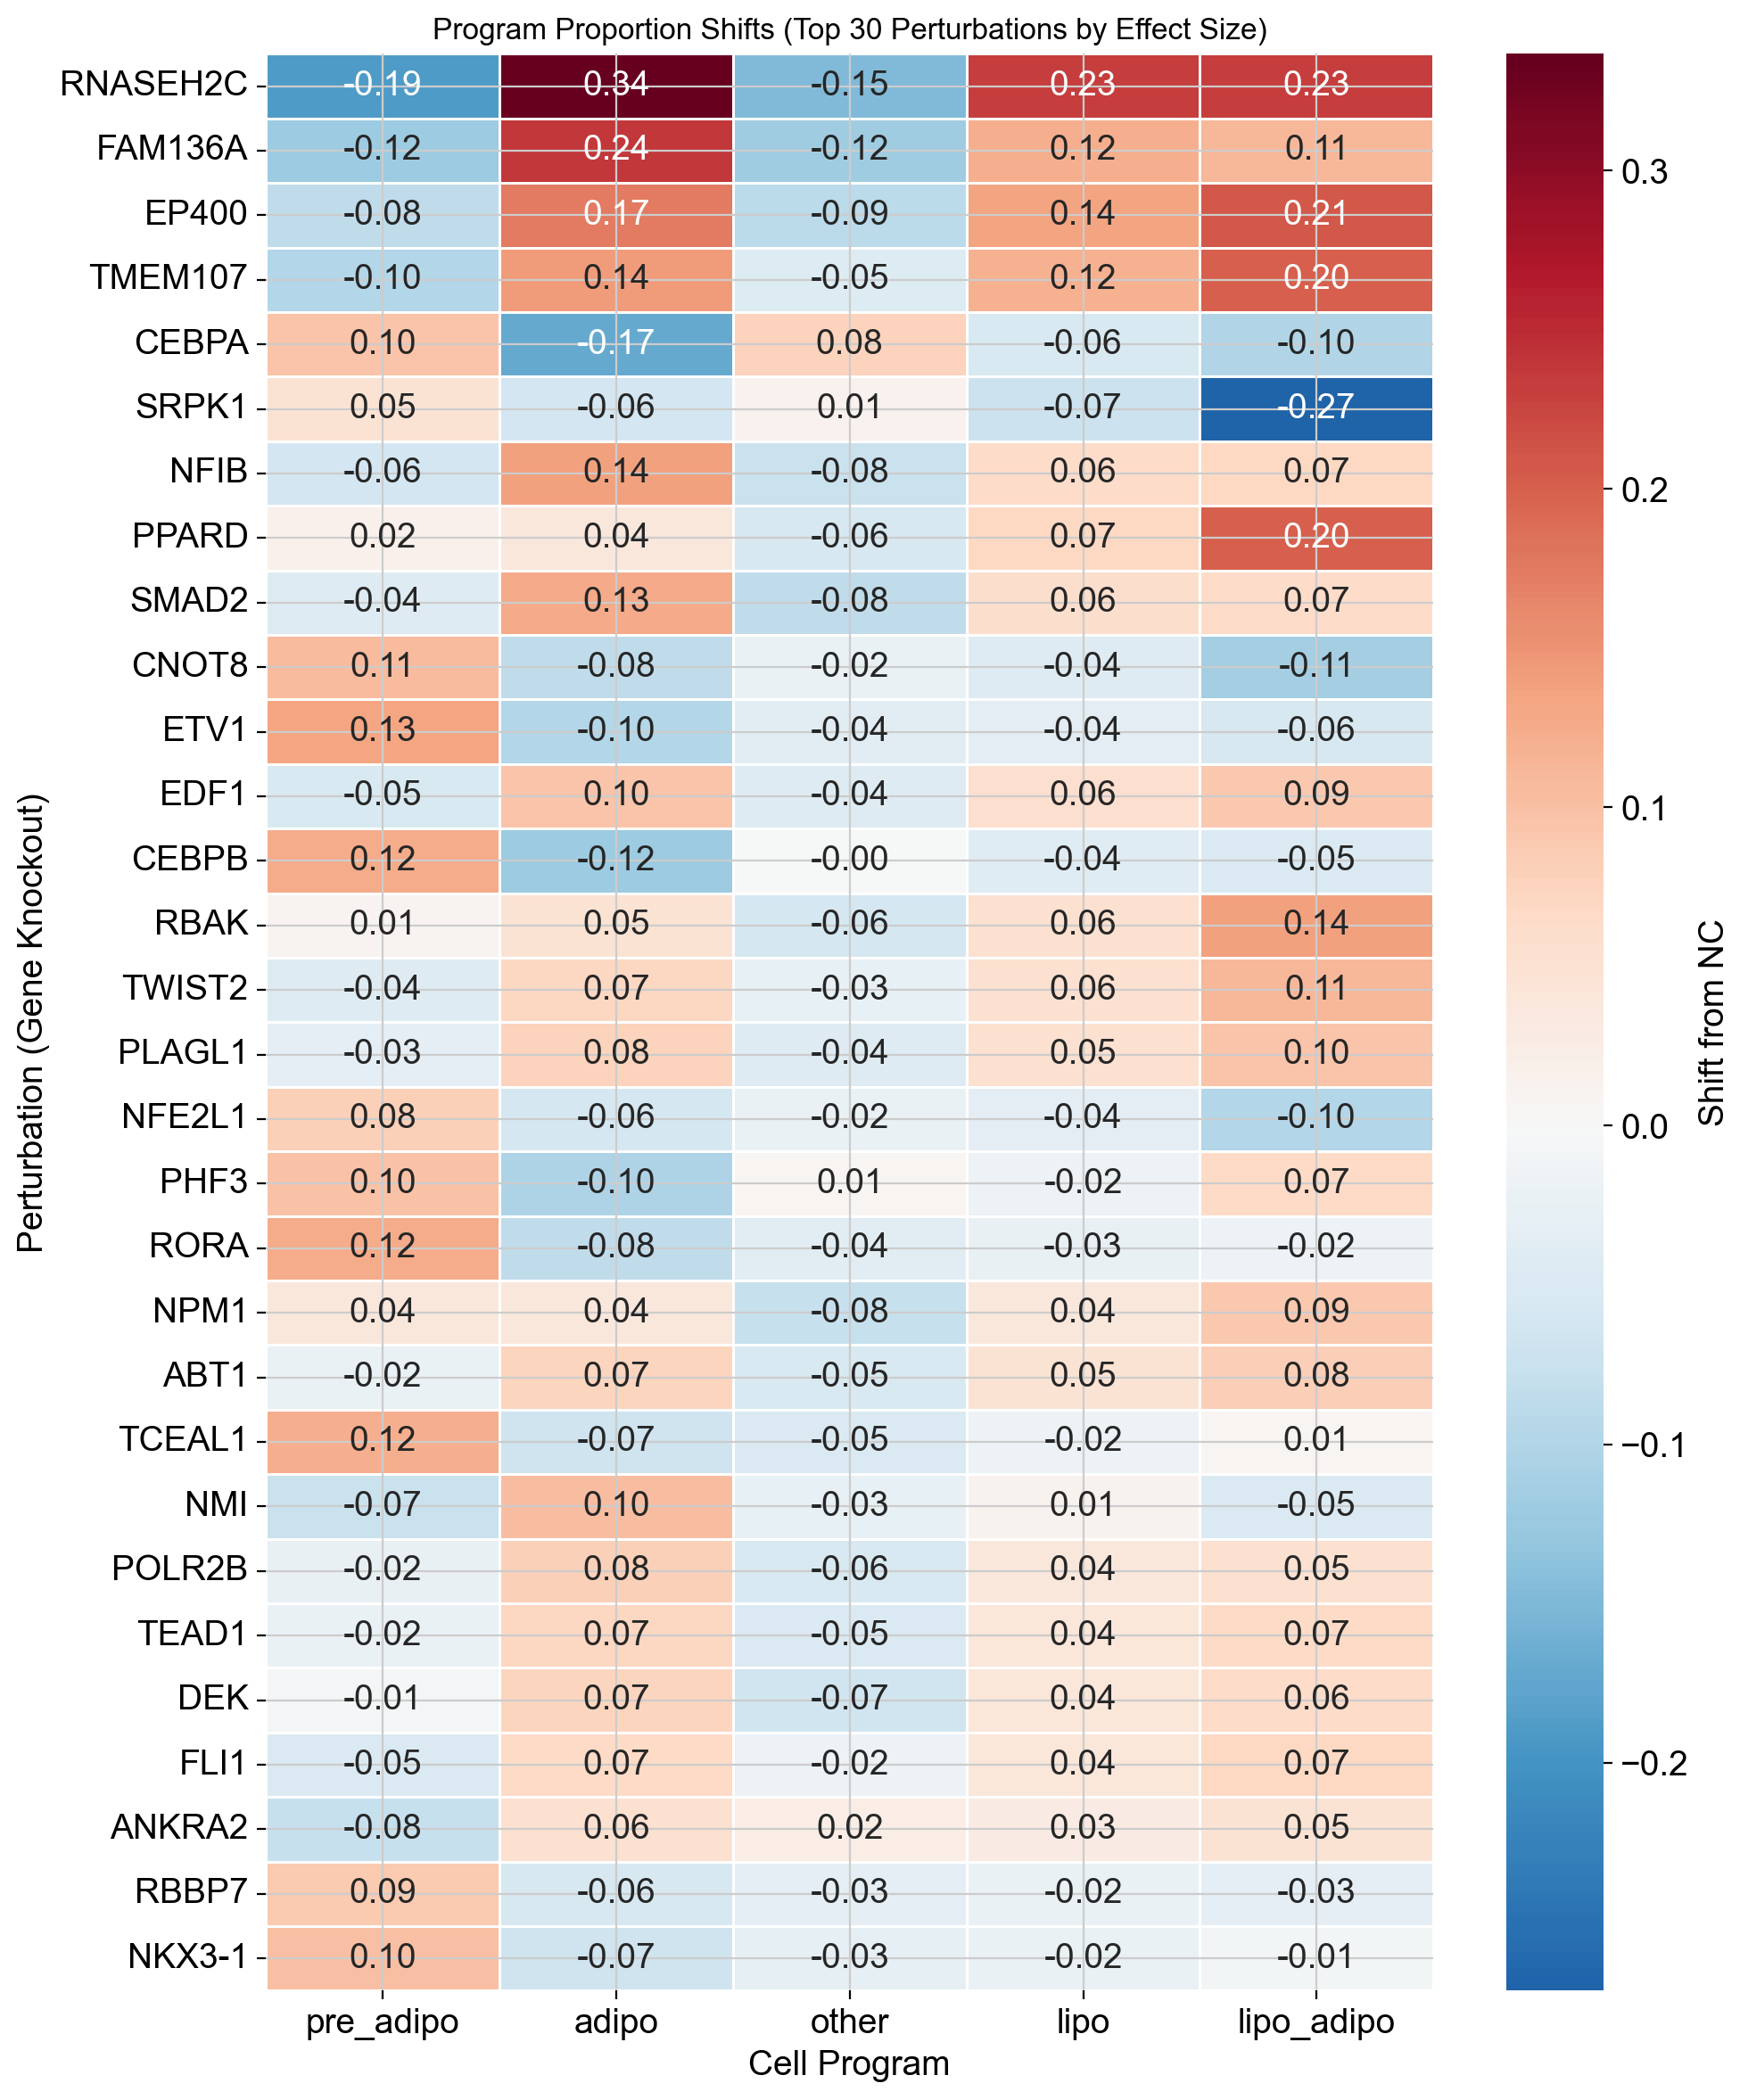

In [13]:
# Heatmap of program shifts for top perturbations
top_perturbs = program_shifts_sorted.head(30).index
shift_matrix = program_shifts_sorted.loc[top_perturbs, ['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo']]

fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(shift_matrix, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            linewidths=0.5, cbar_kws={'label': 'Shift from NC'})
ax.set_title('Program Proportion Shifts (Top 30 Perturbations by Effect Size)', fontsize=12)
ax.set_xlabel('Cell Program')
ax.set_ylabel('Perturbation (Gene Knockout)')
plt.tight_layout()
plt.savefig('figures/program_shift_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Categorize perturbations by their dominant effect
def categorize_effect(row):
    programs = ['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo']
    shifts = row[programs]
    max_shift = shifts.abs().max()
    if max_shift < 0.05:
        return 'Minimal Effect'
    dominant = shifts.abs().idxmax()
    direction = 'Increase' if shifts[dominant] > 0 else 'Decrease'
    return f"{direction} {dominant}"

program_shifts['effect_category'] = program_shifts.apply(categorize_effect, axis=1)
effect_counts = program_shifts['effect_category'].value_counts()

print("Perturbation Effect Categories:")
print(effect_counts)

Perturbation Effect Categories:
effect_category
Minimal Effect         35
Increase lipo_adipo    20
Increase adipo         20
Increase pre_adipo     18
Decrease lipo_adipo    12
Decrease other          8
Decrease adipo          5
Decrease pre_adipo      3
Increase other          1
Name: count, dtype: int64


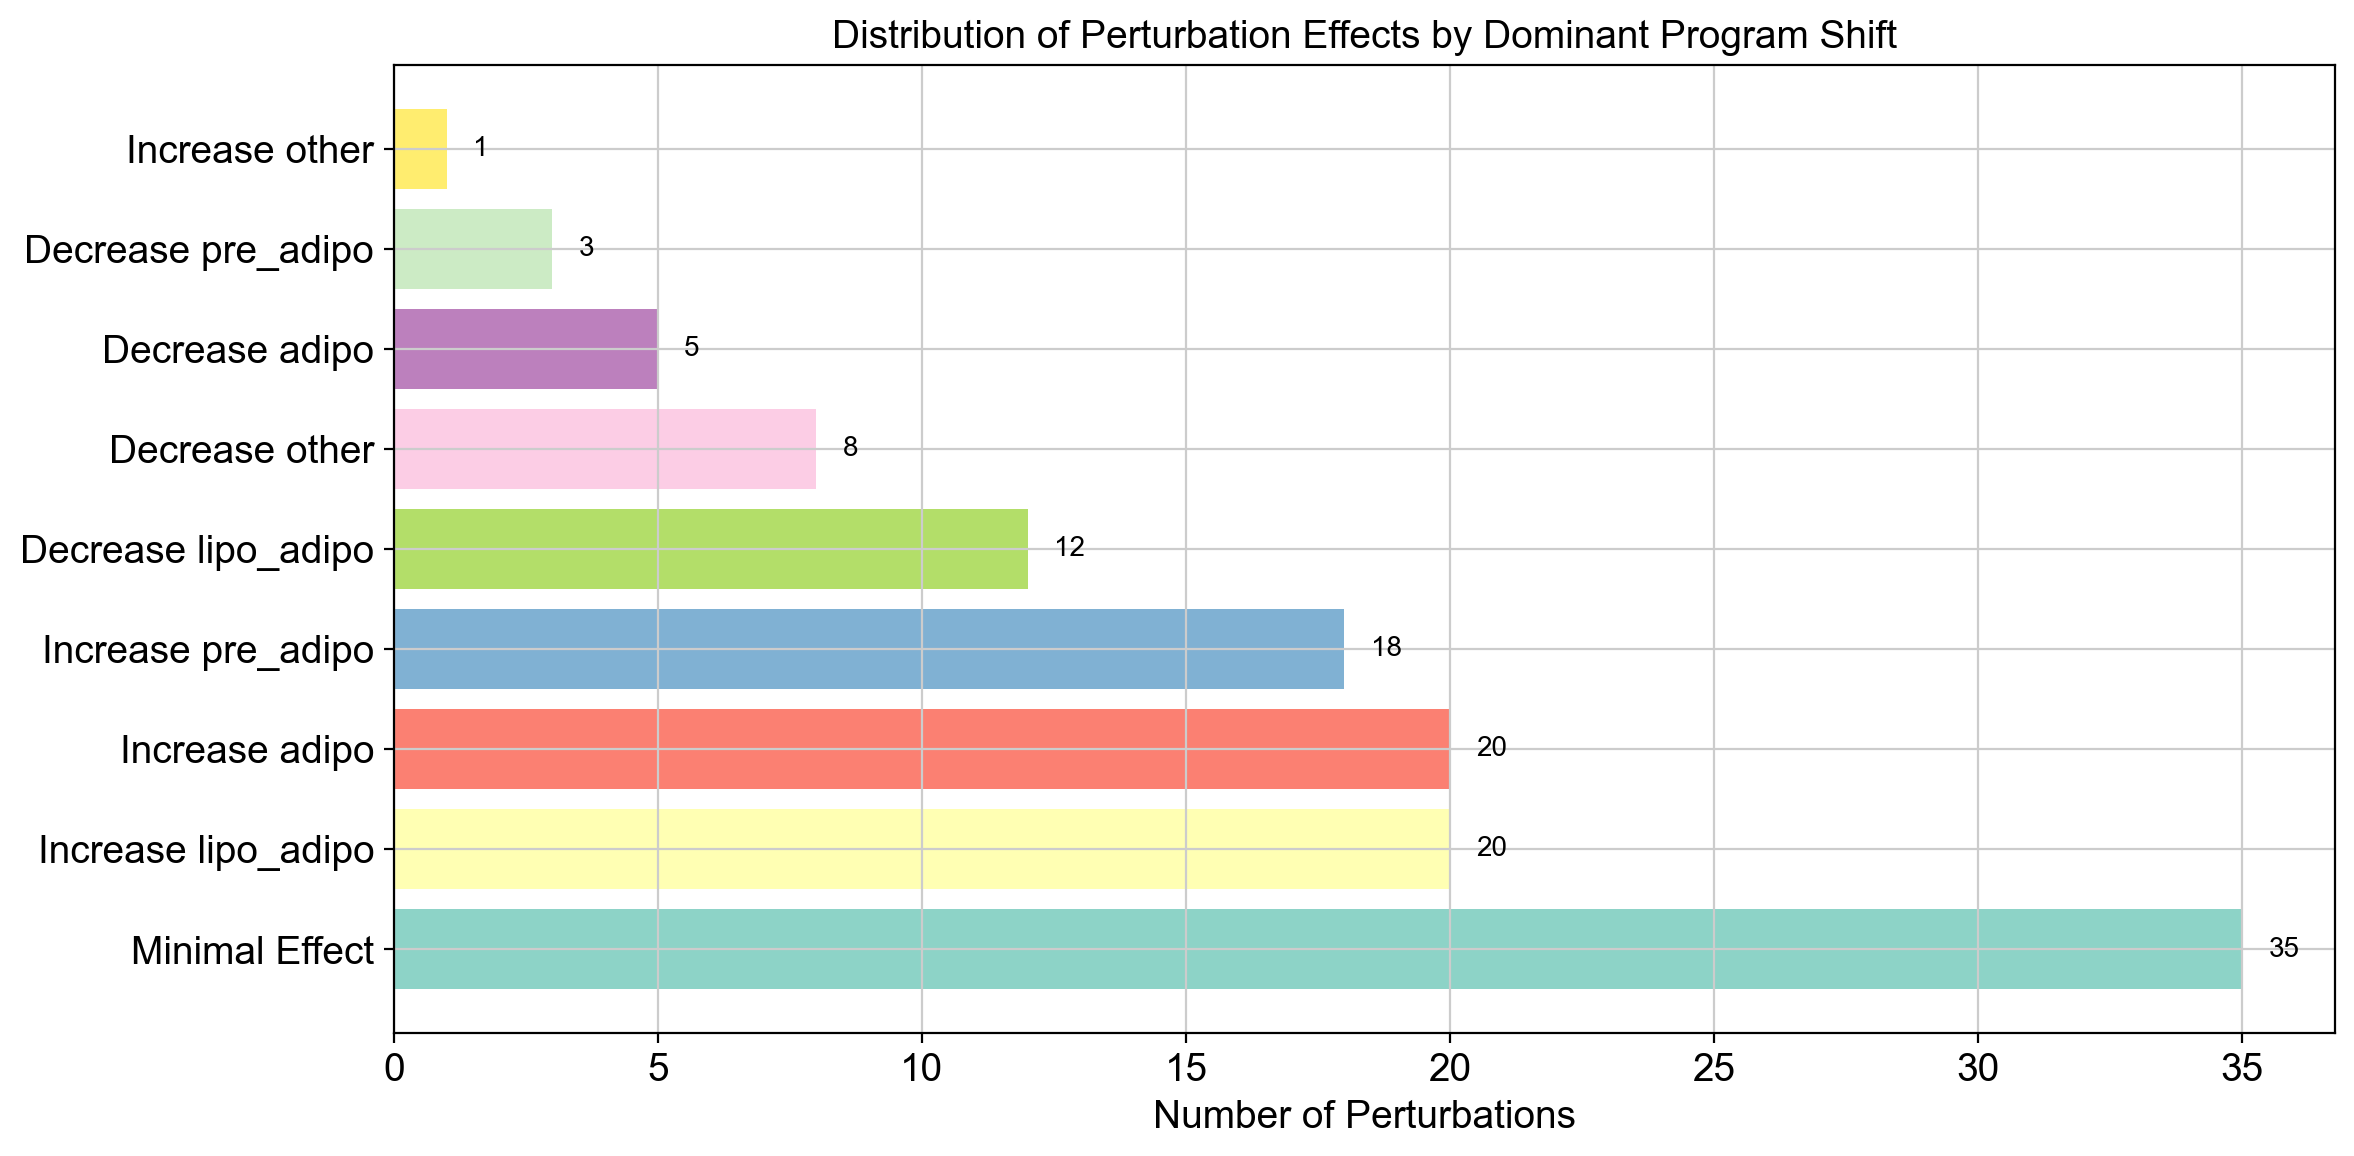

In [15]:
# Visualize effect categories
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Set3(np.linspace(0, 1, len(effect_counts)))
bars = ax.barh(range(len(effect_counts)), effect_counts.values, color=colors)
ax.set_yticks(range(len(effect_counts)))
ax.set_yticklabels(effect_counts.index)
ax.set_xlabel('Number of Perturbations')
ax.set_title('Distribution of Perturbation Effects by Dominant Program Shift')

# Add count labels
for bar, count in zip(bars, effect_counts.values):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            str(count), va='center', fontsize=10)

plt.tight_layout()
plt.savefig('figures/effect_category_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Cluster Perturbations by Expression Profile

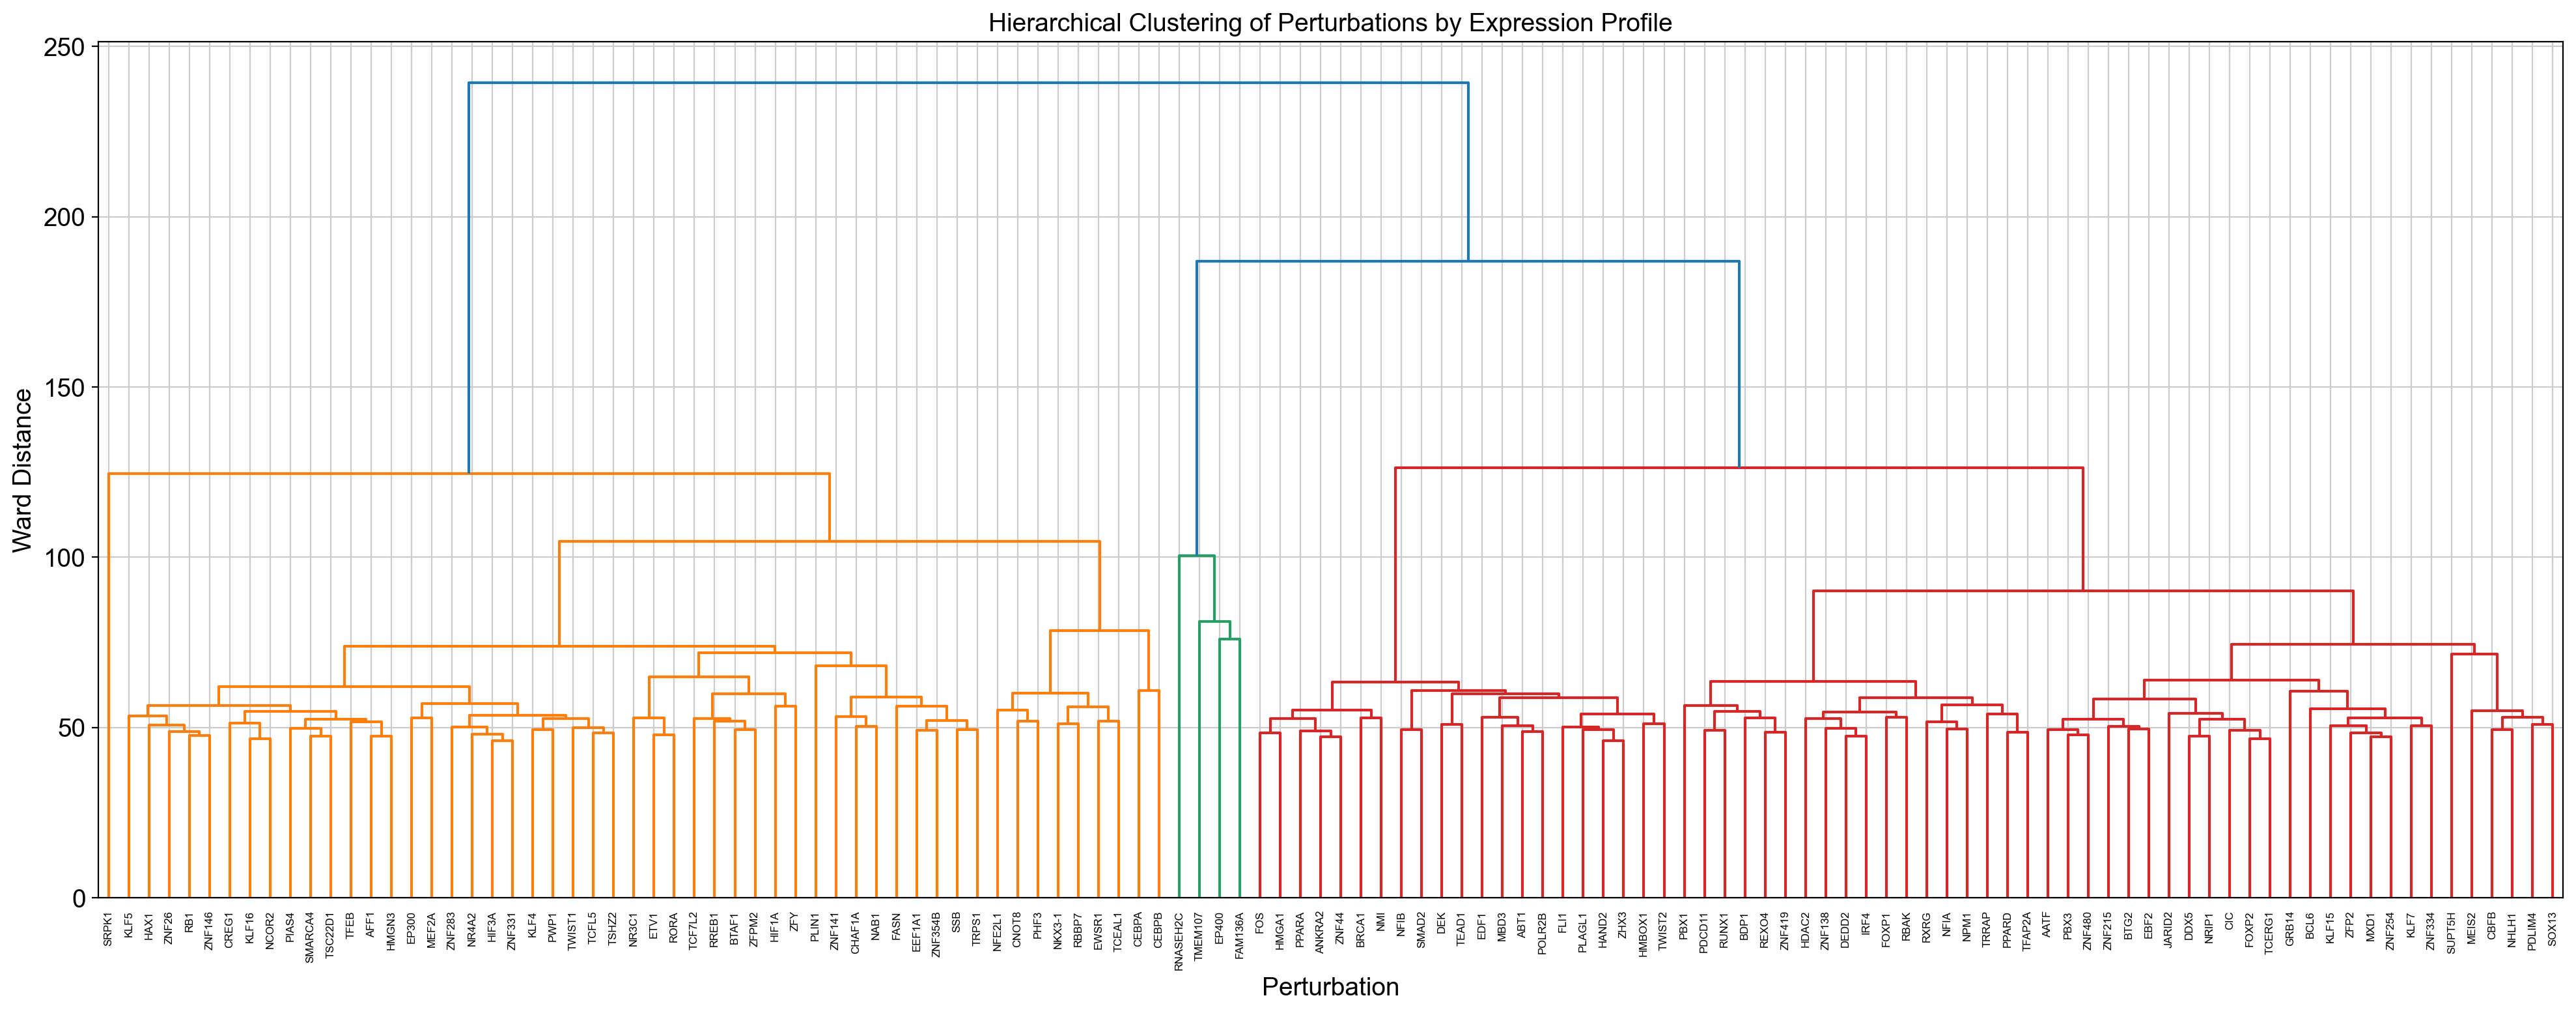

In [16]:
# Z-score normalize centroids for clustering
centroid_zscore = centroid_df.apply(zscore, axis=0)

# Remove NC for clustering analysis
centroid_zscore_noNC = centroid_zscore.drop('NC', errors='ignore')

# Hierarchical clustering
linkage_matrix = linkage(centroid_zscore_noNC, method='ward')

# Create dendrogram
fig, ax = plt.subplots(figsize=(20, 8))
dendrogram(linkage_matrix, labels=centroid_zscore_noNC.index, leaf_rotation=90, leaf_font_size=6)
ax.set_title('Hierarchical Clustering of Perturbations by Expression Profile', fontsize=14)
ax.set_xlabel('Perturbation')
ax.set_ylabel('Ward Distance')
plt.tight_layout()
plt.savefig('figures/perturbation_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Assign clusters
n_clusters = 6
cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
cluster_df = pd.DataFrame({'perturbation': centroid_zscore_noNC.index, 'cluster': cluster_labels})
cluster_df.set_index('perturbation', inplace=True)

print(f"Cluster distribution:")
print(cluster_df['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
1    43
2     9
3     1
4     4
5    21
6    44
Name: count, dtype: int64


In [18]:
# Analyze clusters in terms of program proportions
# Merge cluster assignments with program shifts
cluster_program = cluster_df.join(program_shifts[['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo']], how='inner')

# Compute mean program shift per cluster
cluster_means = cluster_program.groupby('cluster')[['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo']].mean()

print("Mean Program Shifts by Cluster:")
cluster_means

Mean Program Shifts by Cluster:


,pre_adipo,adipo,other,lipo,lipo_adipo
cluster,,,,,
1,0.041922,-0.020957,-0.020964,-0.006633,-0.003870
2,0.097630,-0.090168,-0.007462,-0.029808,-0.034434
3,0.048178,-0.062431,0.014253,-0.069960,-0.271632
4,-0.123099,0.223360,-0.100261,0.151499,0.187796
5,-0.037477,0.072290,-0.034813,0.035093,0.046349
6,-0.000665,0.020894,-0.020229,0.009546,0.012821


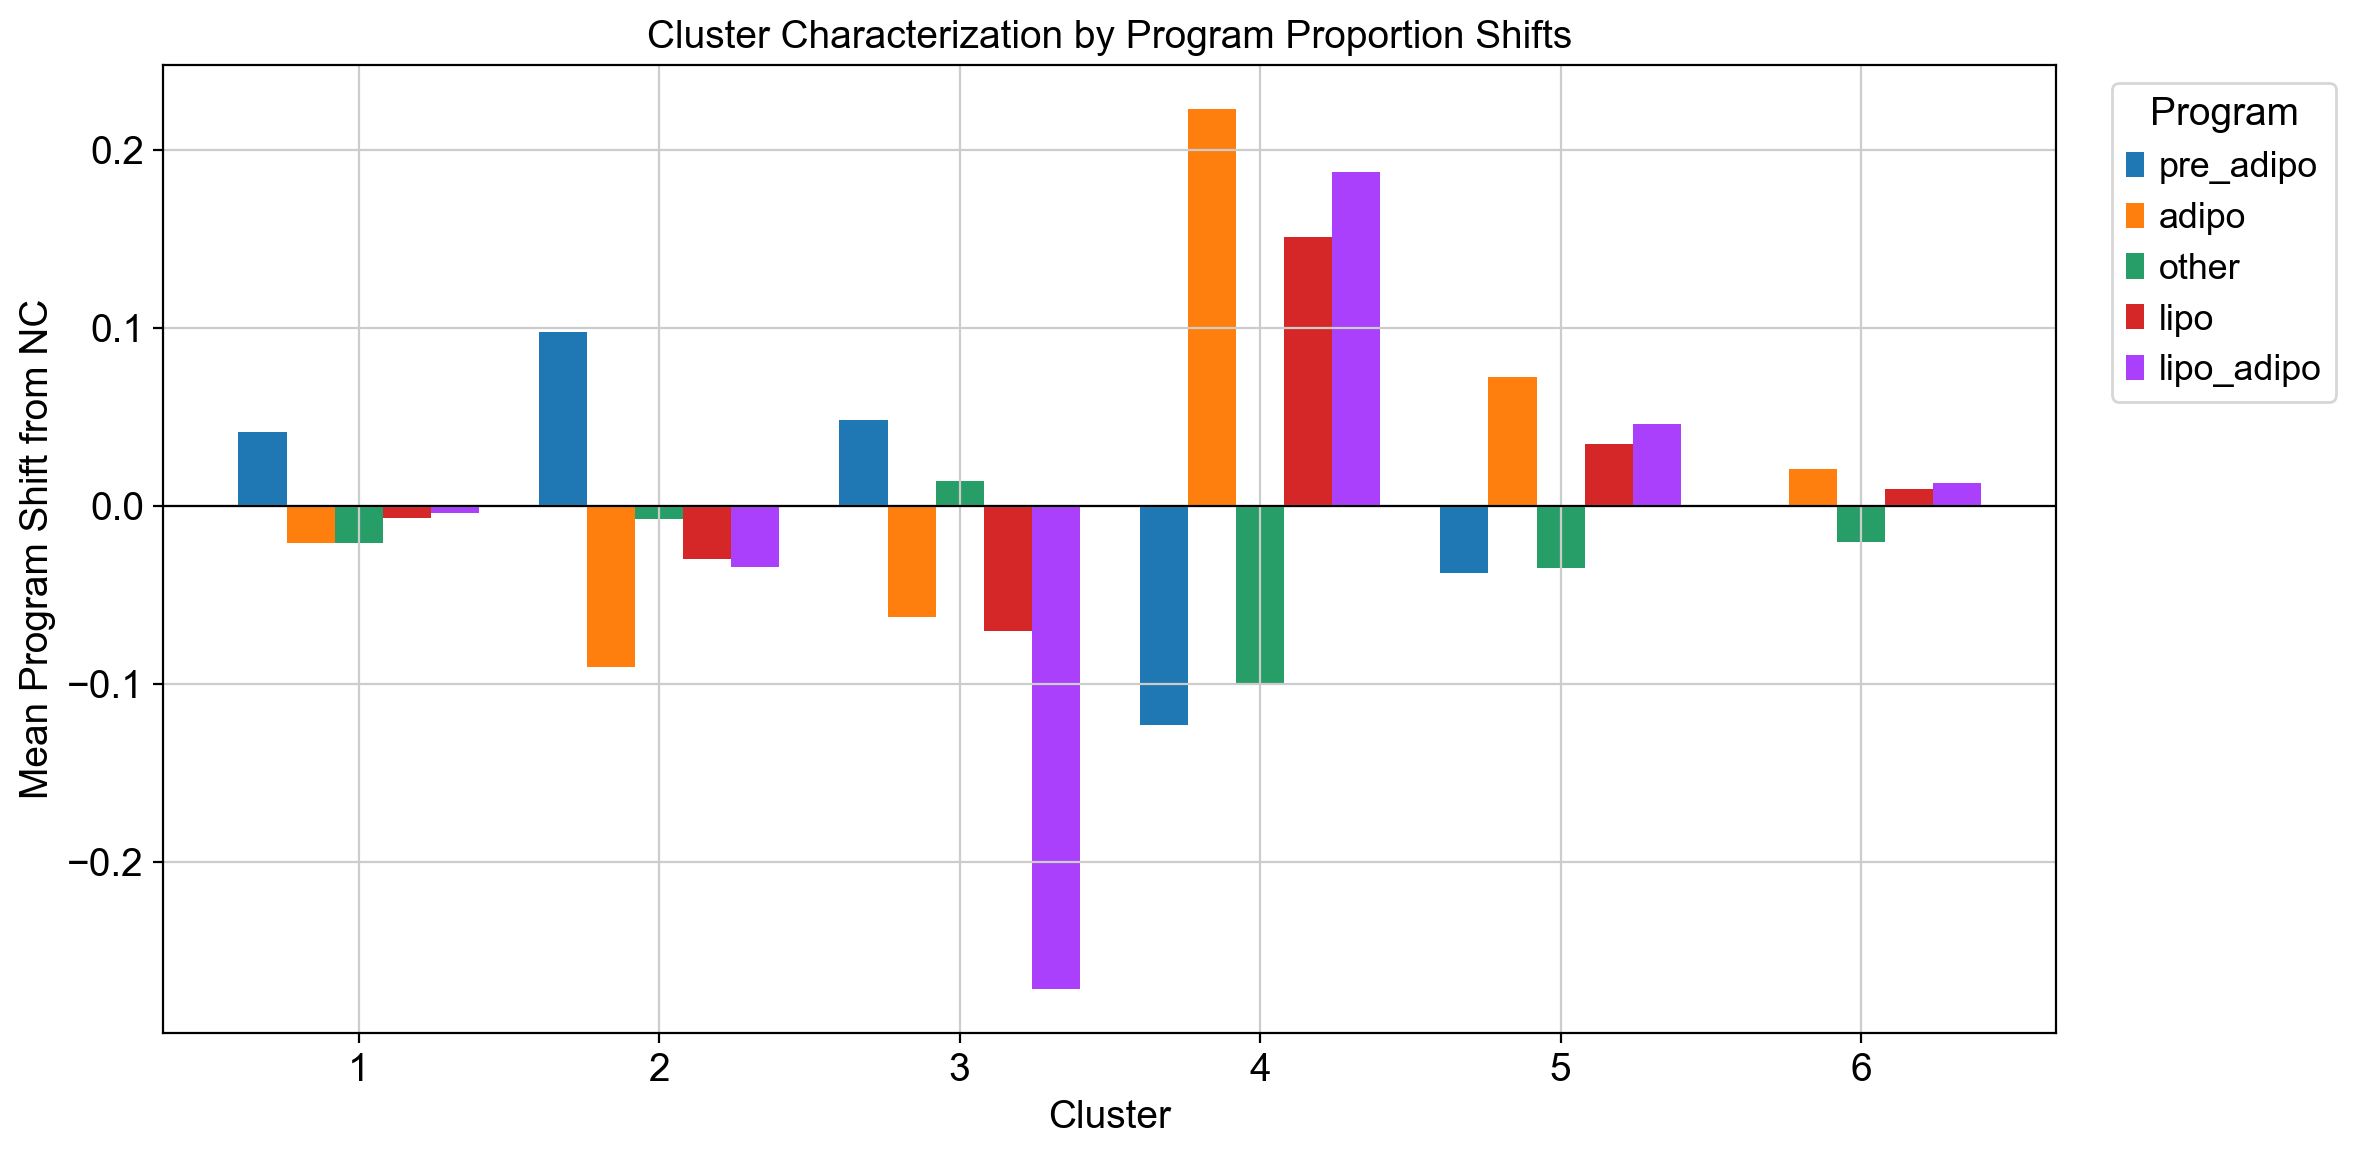

In [19]:
# Visualize cluster characteristics
fig, ax = plt.subplots(figsize=(12, 6))
cluster_means.plot(kind='bar', ax=ax, width=0.8)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean Program Shift from NC')
ax.set_title('Cluster Characterization by Program Proportion Shifts')
ax.legend(title='Program', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/cluster_program_shifts.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. PCA of Perturbation Centroids

In [20]:
from sklearn.decomposition import PCA

# PCA on centroids
pca = PCA(n_components=10)
centroid_pca = pca.fit_transform(centroid_zscore)

# Create DataFrame
pca_df = pd.DataFrame(centroid_pca[:, :3], 
                       index=centroid_zscore.index,
                       columns=['PC1', 'PC2', 'PC3'])

# Add cluster info (NC gets cluster 0)
pca_df['cluster'] = pca_df.index.map(lambda x: cluster_df.loc[x, 'cluster'] if x in cluster_df.index else 0)
pca_df['is_NC'] = pca_df.index == 'NC'

# Add distance info
pca_df['distance_from_NC'] = pca_df.index.map(lambda x: distance_df.loc[x, 'euclidean'] if x in distance_df.index else 0)

print(f"Variance explained: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}, PC3={pca.explained_variance_ratio_[2]:.2%}")

Variance explained: PC1=24.65%, PC2=4.25%, PC3=3.32%


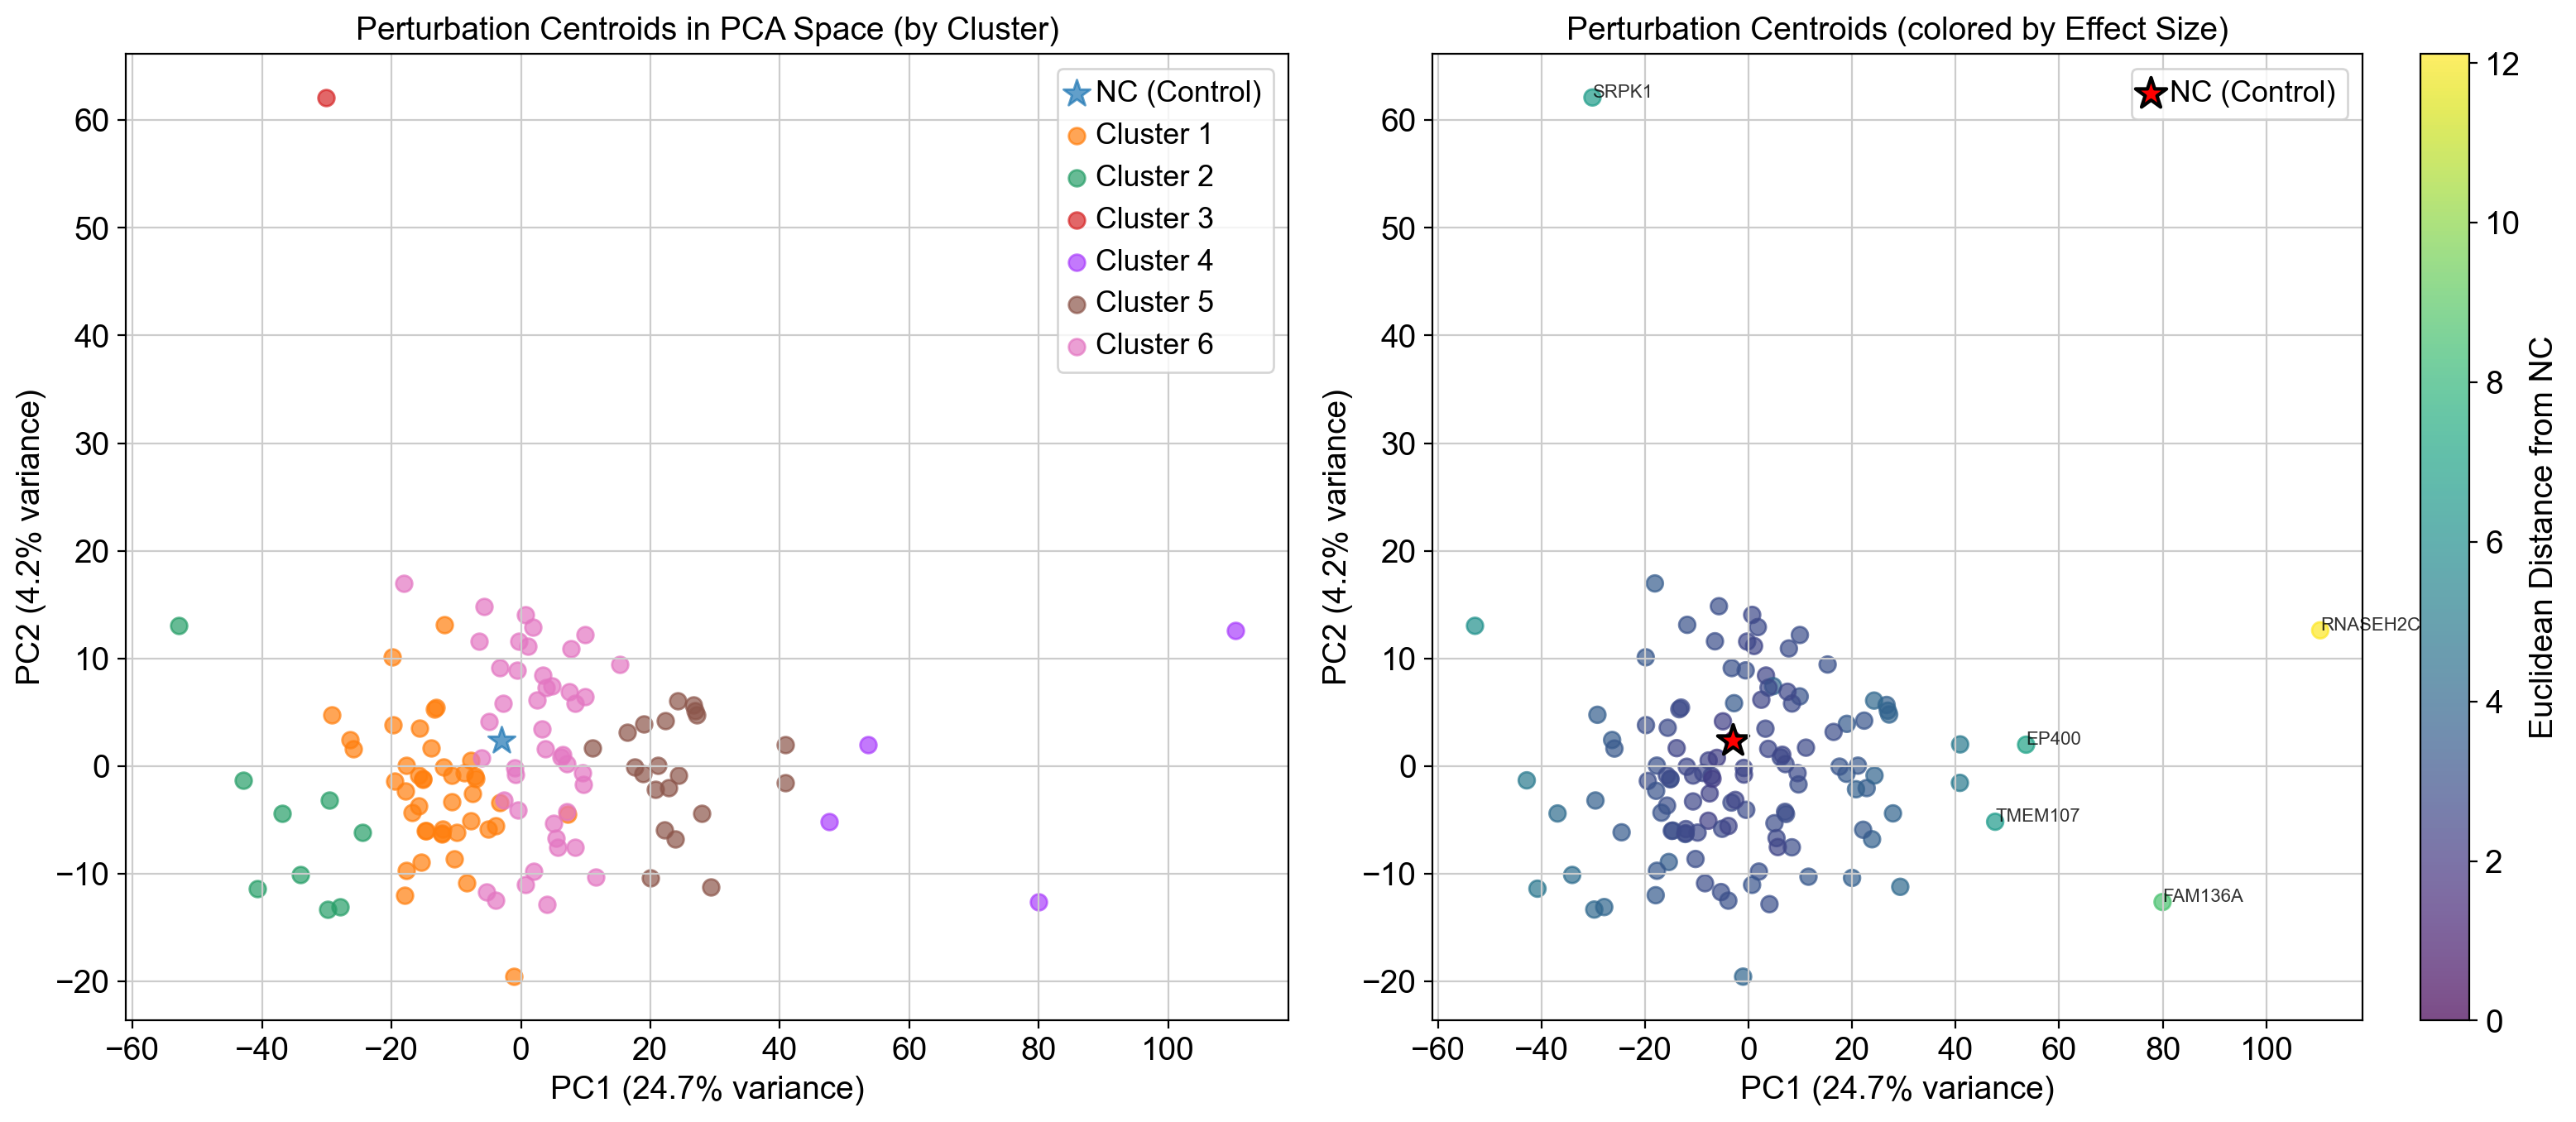

In [21]:
# Plot PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# By cluster
for cluster in sorted(pca_df['cluster'].unique()):
    mask = pca_df['cluster'] == cluster
    label = 'NC (Control)' if cluster == 0 else f'Cluster {cluster}'
    size = 150 if cluster == 0 else 50
    marker = '*' if cluster == 0 else 'o'
    axes[0].scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                    label=label, s=size, marker=marker, alpha=0.7)

axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[0].set_title('Perturbation Centroids in PCA Space (by Cluster)')
axes[0].legend(loc='best')

# By distance from NC
scatter = axes[1].scatter(pca_df['PC1'], pca_df['PC2'], 
                          c=pca_df['distance_from_NC'], cmap='viridis', 
                          s=50, alpha=0.7)
# Highlight NC
nc_row = pca_df.loc['NC']
axes[1].scatter(nc_row['PC1'], nc_row['PC2'], c='red', s=200, marker='*', 
                label='NC (Control)', edgecolors='black', linewidths=1.5)

# Annotate top perturbations
top_perturbs = distance_df.head(5).index
for pert in top_perturbs:
    if pert in pca_df.index:
        axes[1].annotate(pert, (pca_df.loc[pert, 'PC1'], pca_df.loc[pert, 'PC2']),
                         fontsize=8, alpha=0.8)

plt.colorbar(scatter, ax=axes[1], label='Euclidean Distance from NC')
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[1].set_title('Perturbation Centroids (colored by Effect Size)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.savefig('figures/perturbation_pca.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Gene-Level Analysis of Perturbation Effects

In [22]:
# Compute differential expression (centroid difference from NC) for each gene
diff_from_nc = centroid_df.drop('NC').subtract(nc_centroid, axis=1)

# Find genes with highest variance across perturbations (most affected by knockouts)
gene_variance = diff_from_nc.var(axis=0).sort_values(ascending=False)

print("Top 30 genes most affected by perturbations (highest variance):")
print(gene_variance.head(30))

Top 30 genes most affected by perturbations (highest variance):
GRIK2       0.055249
PRKAR2B     0.039154
PLIN1       0.037958
PENK        0.036738
APOE        0.036735
AOC3        0.035980
GPD1        0.035629
IGFBP2      0.033738
ITGA7       0.031873
CITED1      0.030443
CLMN        0.030323
PRKG1       0.030195
PPP1R1B     0.030190
PLIN4       0.030178
LIPE        0.029992
PPP1R1A     0.029239
GREM1       0.028843
CYP1B1      0.028758
RBP4        0.028327
LGALS12     0.028033
PLA2G2A     0.027872
ADIPOQ      0.027819
ATP1A2      0.027330
PRG4        0.027033
SERPINE1    0.026887
MEDAG       0.026709
ITGBL1      0.025791
UCP2        0.025618
AGT         0.025386
IGFBP6      0.024909
dtype: float64


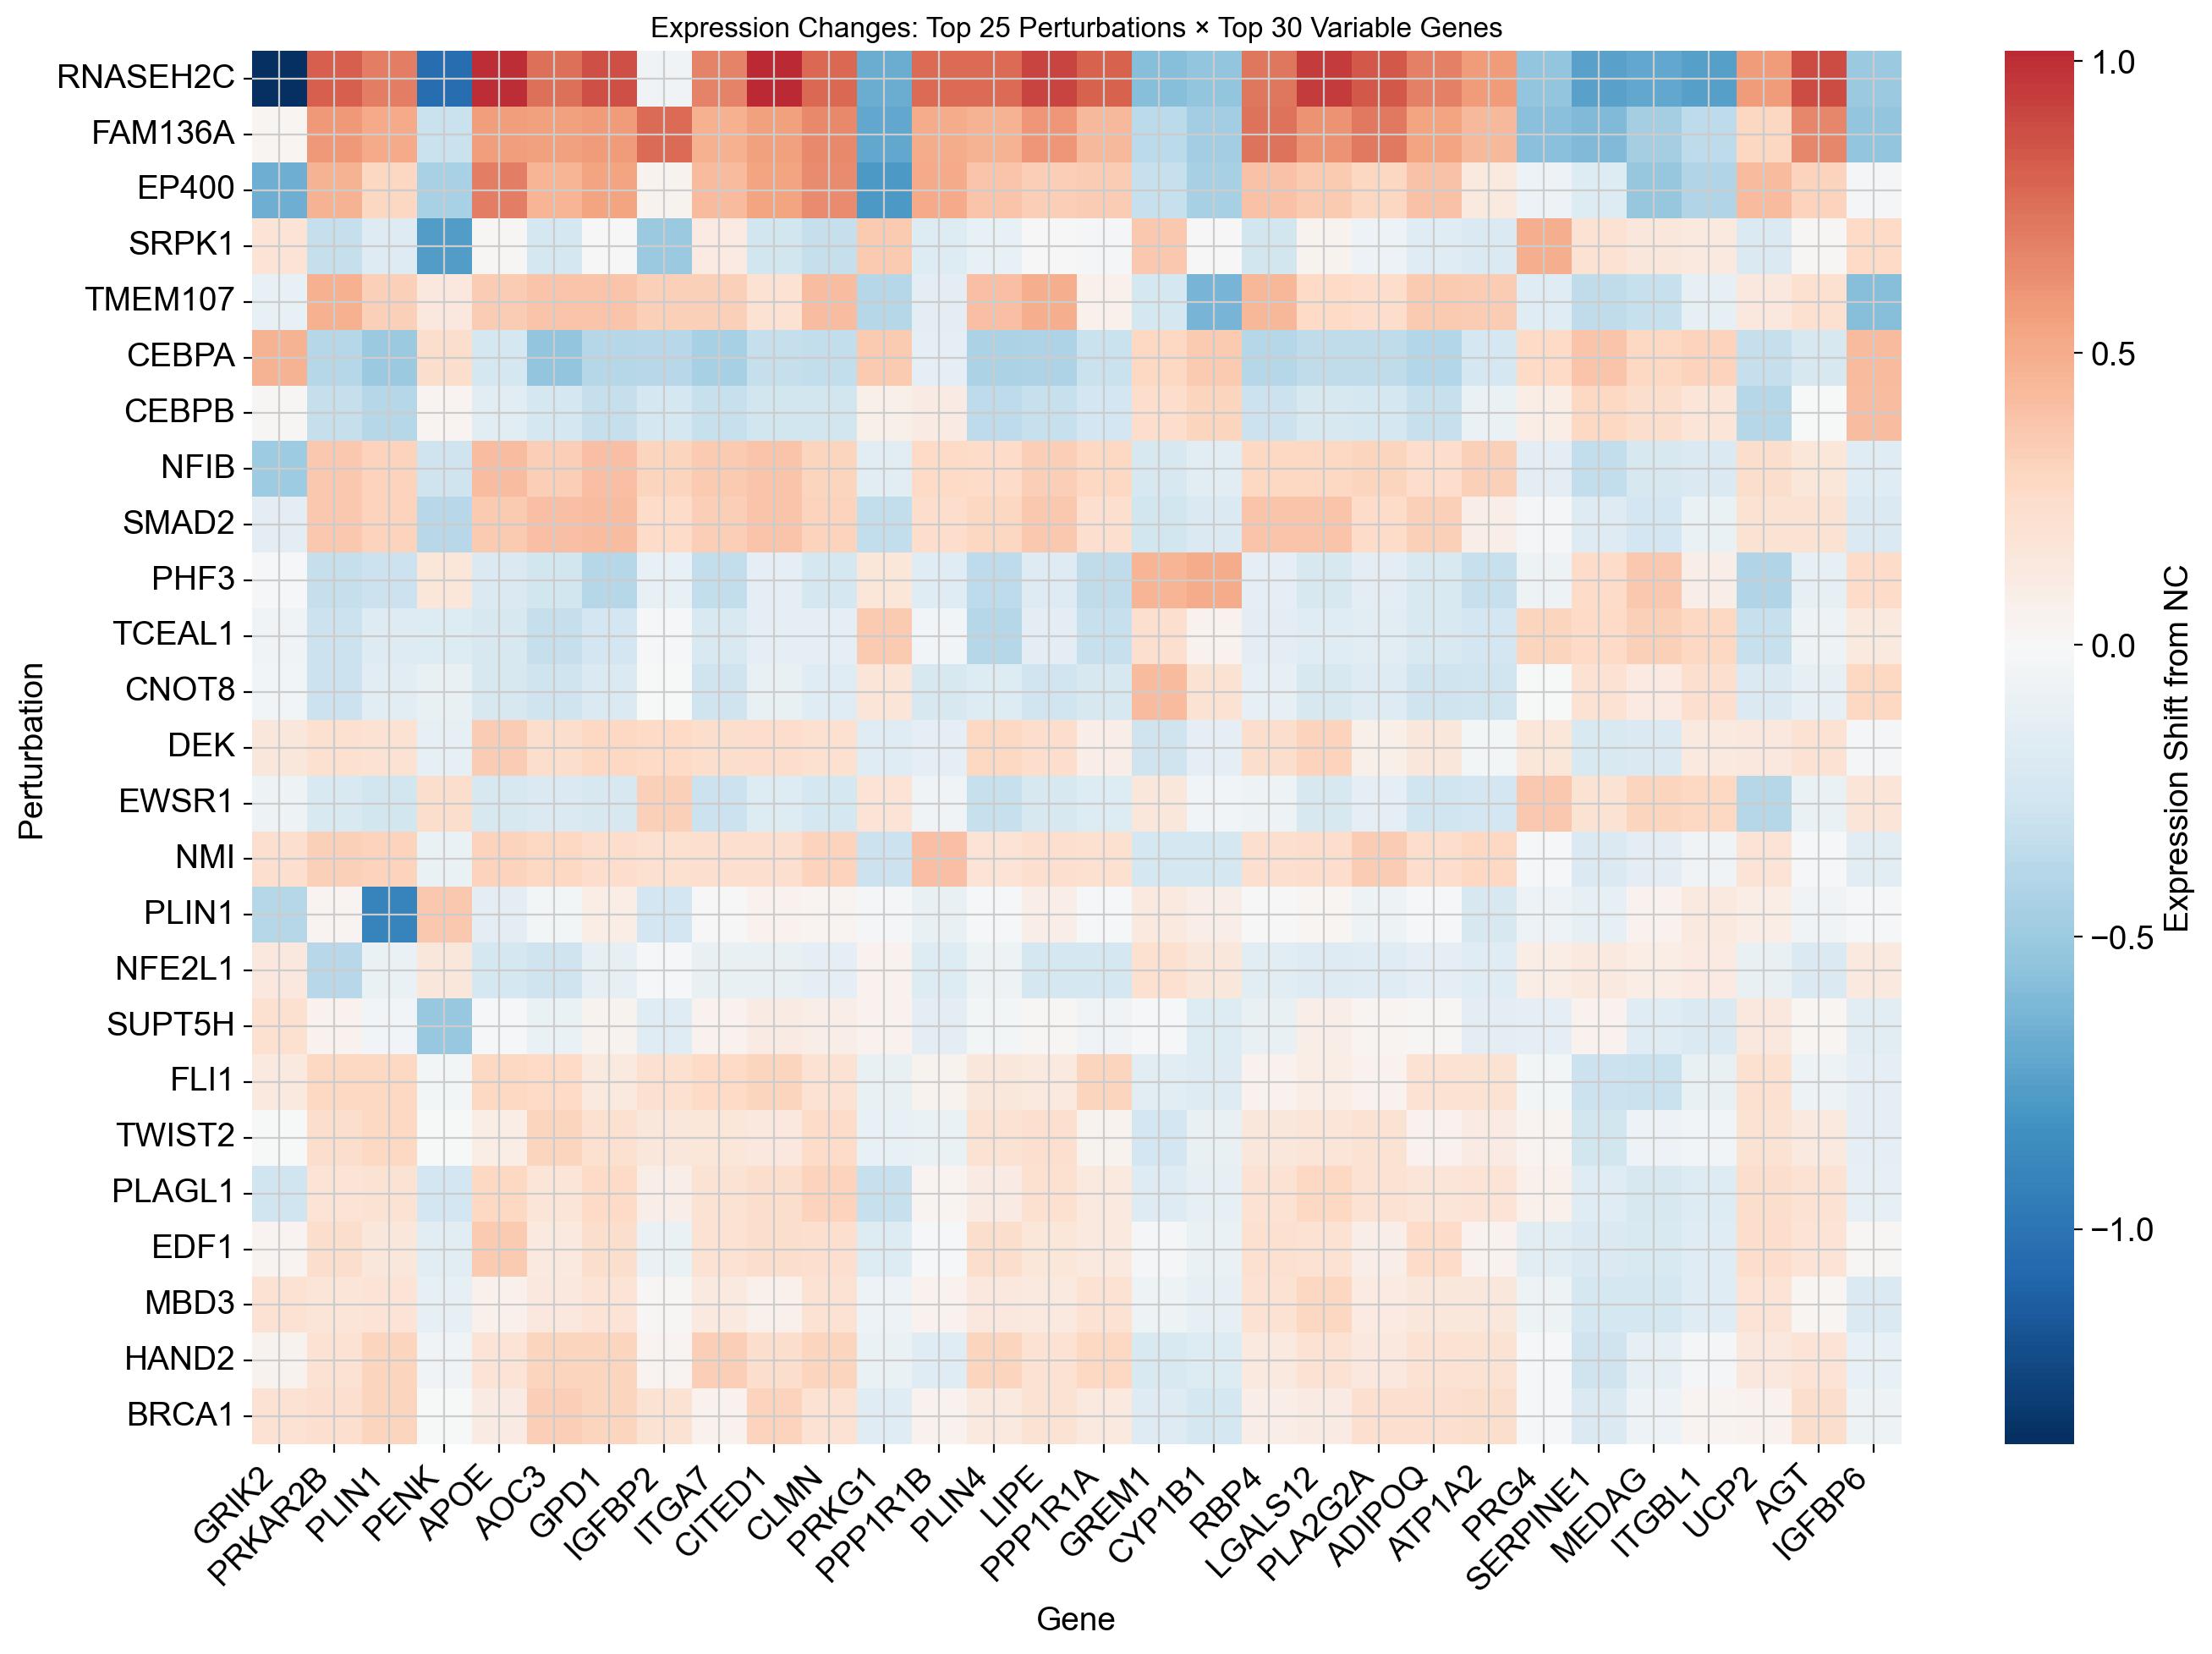

In [23]:
# Heatmap of top variable genes across strongest perturbations
top_genes = gene_variance.head(30).index.tolist()
top_perturbs = distance_df.head(25).index.tolist()

diff_subset = diff_from_nc.loc[top_perturbs, top_genes]

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(diff_subset, cmap='RdBu_r', center=0, 
            xticklabels=True, yticklabels=True,
            cbar_kws={'label': 'Expression Shift from NC'})
ax.set_title('Expression Changes: Top 25 Perturbations × Top 30 Variable Genes', fontsize=12)
ax.set_xlabel('Gene')
ax.set_ylabel('Perturbation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/perturbation_gene_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary Statistics and Export

In [24]:
# Create comprehensive summary DataFrame
summary_df = distance_df.copy()
summary_df = summary_df.join(program_shifts[['pre_adipo', 'adipo', 'other', 'lipo', 'lipo_adipo', 'total_shift', 'effect_category']])
summary_df = summary_df.join(cluster_df)

# Sort by effect size
summary_df = summary_df.sort_values('euclidean', ascending=False)

# Save to CSV
summary_df.to_csv('perturbation_analysis_summary.csv')
print(f"Summary saved to perturbation_analysis_summary.csv")
print(f"\nSummary shape: {summary_df.shape}")
summary_df.head(20)

Summary saved to perturbation_analysis_summary.csv

Summary shape: (122, 11)


,euclidean,cosine,cell_count,pre_adipo,adipo,other,lipo,lipo_adipo,total_shift,effect_category,cluster
RNASEH2C,12.122114,0.018520,300.0,-0.188737,0.336611,-0.147874,0.229775,0.232832,1.135829,Increase adipo,4
FAM136A,8.606647,0.009391,294.0,-0.121558,0.239046,-0.117487,0.120516,0.111929,0.710537,Increase adipo,4
EP400,6.968398,0.006097,300.0,-0.084512,0.174391,-0.089880,0.136985,0.207467,0.693234,Increase lipo_adipo,4
SRPK1,6.641146,0.005317,41.0,0.048178,-0.062431,0.014253,-0.069960,-0.271632,0.466455,Decrease lipo_adipo,3
TMEM107,6.599903,0.005516,212.0,-0.097588,0.143390,-0.045802,0.118719,0.198956,0.604456,Increase lipo_adipo,4
CEBPA,6.094033,0.004676,300.0,0.095408,-0.170689,0.075280,-0.055129,-0.100901,0.497407,Decrease adipo,2
CEBPB,4.963653,0.003116,294.0,0.123340,-0.121499,-0.001841,-0.039348,-0.046632,0.332660,Increase pre_adipo,2
NFIB,4.893386,0.003029,300.0,-0.061735,0.137297,-0.075562,0.064518,0.068947,0.408059,Increase adipo,5
SMAD2,4.886303,0.003017,300.0,-0.041556,0.125936,-0.084380,0.059201,0.065173,0.376246,Increase adipo,5
PHF3,4.739094,0.002840,300.0,0.096747,-0.103873,0.007126,-0.018012,0.066396,0.292154,Decrease adipo,2


In [25]:
# Save centroids for downstream analysis
centroid_df.to_csv('perturbation_centroids.csv')
print("Centroids saved to perturbation_centroids.csv")

# Save the top variable genes
gene_variance.to_csv('gene_perturbation_variance.csv', header=['variance'])
print("Gene variance saved to gene_perturbation_variance.csv")

Centroids saved to perturbation_centroids.csv
Gene variance saved to gene_perturbation_variance.csv


In [26]:
# Final summary statistics
print("="*70)
print("PERTURBATION ANALYSIS SUMMARY")
print("="*70)
print(f"\nTotal perturbations analyzed: {len(distance_df)}")
print(f"Total cells in dataset: {adata.n_obs}")
print(f"Features used (HVGs): {len(hvgs_in_data)}")
print(f"\n--- Effect Size Statistics ---")
print(f"Mean Euclidean distance from NC: {distance_df['euclidean'].mean():.3f}")
print(f"Median Euclidean distance from NC: {distance_df['euclidean'].median():.3f}")
print(f"Max Euclidean distance from NC: {distance_df['euclidean'].max():.3f} ({distance_df['euclidean'].idxmax()})")
print(f"Min Euclidean distance from NC: {distance_df['euclidean'].min():.3f} ({distance_df['euclidean'].idxmin()})")
print(f"\n--- Program Shift Statistics ---")
print(f"Mean total program shift: {program_shifts['total_shift'].mean():.3f}")
print(f"Max total program shift: {program_shifts['total_shift'].max():.3f} ({program_shifts['total_shift'].idxmax()})")
print(f"\n--- Effect Category Distribution ---")
for cat, count in effect_counts.items():
    print(f"  {cat}: {count} perturbations ({count/len(program_shifts)*100:.1f}%)")
print(f"\n--- Cluster Distribution ---")
for cluster, count in cluster_df['cluster'].value_counts().sort_index().items():
    print(f"  Cluster {cluster}: {count} perturbations")
print("="*70)

PERTURBATION ANALYSIS SUMMARY

Total perturbations analyzed: 122
Total cells in dataset: 44846
Features used (HVGs): 2000

--- Effect Size Statistics ---
Mean Euclidean distance from NC: 3.340
Median Euclidean distance from NC: 2.936
Max Euclidean distance from NC: 12.122 (RNASEH2C)
Min Euclidean distance from NC: 2.195 (ZNF331)

--- Program Shift Statistics ---
Mean total program shift: 0.196
Max total program shift: 1.136 (RNASEH2C)

--- Effect Category Distribution ---
  Minimal Effect: 35 perturbations (28.7%)
  Increase lipo_adipo: 20 perturbations (16.4%)
  Increase adipo: 20 perturbations (16.4%)
  Increase pre_adipo: 18 perturbations (14.8%)
  Decrease lipo_adipo: 12 perturbations (9.8%)
  Decrease other: 8 perturbations (6.6%)
  Decrease adipo: 5 perturbations (4.1%)
  Decrease pre_adipo: 3 perturbations (2.5%)
  Increase other: 1 perturbations (0.8%)

--- Cluster Distribution ---
  Cluster 1: 43 perturbations
  Cluster 2: 9 perturbations
  Cluster 3: 1 perturbations
  Cluster